# Notebook configuration

In [9]:
run_number    = 4074
run_tag       = "alpha" # "alpha" or "kr"
data_filename = "$DATADIR/{0}/dst_{0}.root.h5".format(run_number)
text_filename = "$ICARODIR/icaro/Lifetime/Lifetimes.txt"
run_comment   = ""
overwrite     = False

Xrange        = -200, 200
Yrange        = -200, 200
Zrange        =    0, 600
Zrange_LT     =   50, 500
Xnbins        =   50
Ynbins        =   50
Znbins        =   50
Tnbins        =   50
S1nbins       =   50
S2nbins       =   50

XYrange       = Xrange, Yrange
XYnbins       = Xnbins, Ynbins

if   run_tag == "alpha":
    S1range   =    0, 3e3
    S2range   =    0, 4e4
elif run_tag == "kr":
    S1range   =    0, 5e1
    S2range   =    0, 2e4

Rfiducial     = 100 # in mm
Zcathode      = 500 # in µs

# Alpha lifetime

In [20]:
import os
import sys
import argparse
import datetime

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.reco. dst_functions as dstf
import invisible_cities.core. fit_functions as fitf
import invisible_cities.database.load_db    as db

from invisible_cities.icaro.hst_functions import plot
from invisible_cities.icaro.hst_functions import errorbar
from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string

from icaro.core.kdst_functions import event_rate
from icaro.core.kdst_functions import profile_and_fit
from icaro.core.kdst_functions import time_from_timestamp
from icaro.core.kdst_functions import to_deltatime
from icaro.core.kdst_functions import lifetime_vs_t
from icaro.core.kdst_functions import save_lifetime

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-08-25 17:44:49


In [11]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"         ] = 16, 12
plt.rcParams[  "font.size"            ] = 18
plt.rcParams["figure.max_open_warning"] = 1000

# Read data

In [12]:
full       = dstf.load_dst(os.path.expandvars(data_filename), "DST", "Events")
t_begin    = np.min(full.time)
t_end      = np.max(full.time)
run_dt     = t_end - t_begin
full.time -= t_begin
fid        = full[full.R < Rfiducial] # michel sorel cuts
cath       = full[full.Z > Zcathode ]
bulk       = full[full.Z < Zcathode ]

print(f"# alphas              :"        , len(full))
print(f"# alphas at R < {Rfiducial} mm:", len(fid ))
print(f"# alphas at Z > {Zcathode} µs:" , len(cath))
print(f"# alphas at Z < {Zcathode} µs:" , len(bulk))

full.head()

# alphas              : 18420
# alphas at R < 100 mm: 4990
# alphas at Z > 500 µs: 542
# alphas at Z < 500 µs: 17878


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,0.000,0,1,275.0,356.742310,1966.679146,216450.0,10.966000,2520.960938,...,654887.5,10,438.4375,438.4375,-45.182123,-138.062274,145.267394,-1.887070,7.489001,8.690514
1,2,0.175,0,1,350.0,254.454712,1558.020130,553100.0,6.887500,4405.873047,...,653462.5,9,100.3625,100.3625,164.532294,65.722908,177.173295,0.380035,7.174754,6.755964
2,3,0.282,0,1,325.0,248.678024,1510.688494,647975.0,4.177625,9481.593750,...,651512.5,7,3.5375,3.5375,70.593458,-124.938606,143.502932,-1.056491,5.786842,5.185477
3,5,0.451,0,1,300.0,288.811981,1675.163487,388750.0,9.750625,3250.141113,...,655112.5,9,266.3625,266.3625,105.818062,23.792601,108.459901,0.221166,7.573740,7.565556
4,6,0.563,0,1,300.0,318.397736,1796.729677,318200.0,8.946063,1177.326172,...,653512.5,5,335.3125,335.3125,-189.105319,-72.921724,202.678069,-2.773549,4.926804,6.792970


# Trigger rate

Average trigger rate: 4.74 Hz


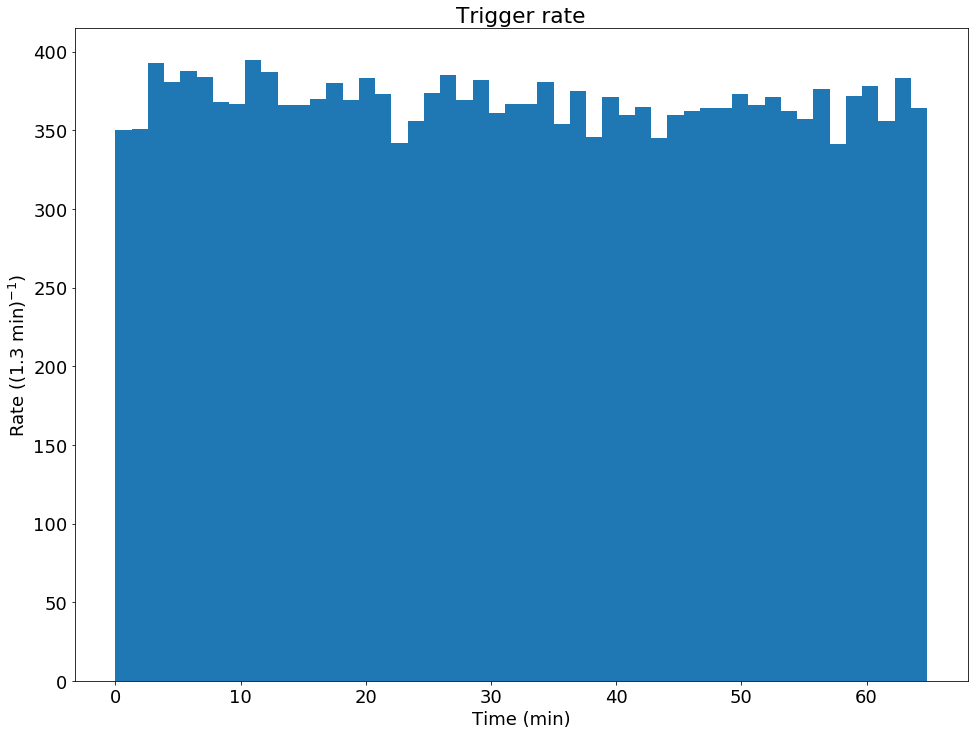

In [13]:
_, bins, _ = \
hist  (full.time/60, Tnbins)
labels("Time (min)",
       "Rate (({:.1f} min)$^{{-1}}$)".format(np.diff(bins)[0]),
       "Trigger rate")

rate = event_rate(full)
print("Average trigger rate: {:.2f} Hz".format(rate))

# Energy distributions and correlations

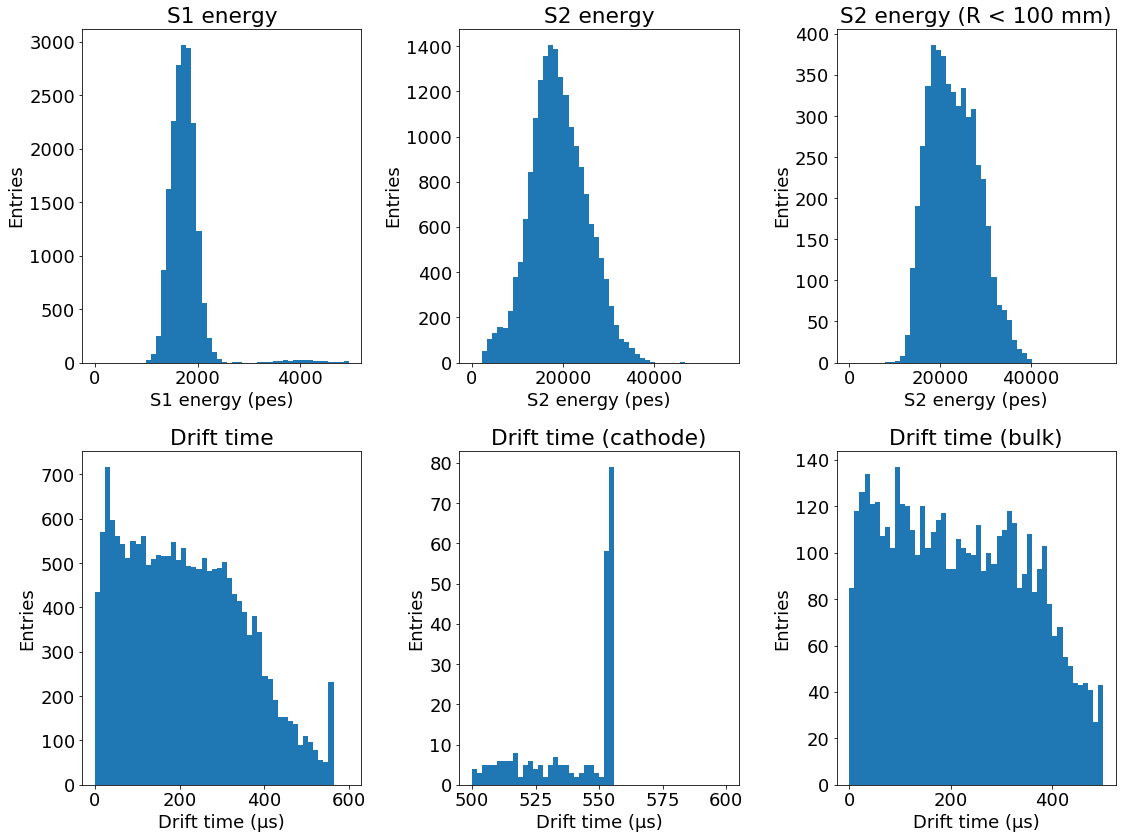

In [14]:
plt.figure ()
plt.subplot(2, 3, 1)
plt.hist   (full.S1e, S1nbins, (0, np.max(full.S1e)))
labels     ("S1 energy (pes)", "Entries", "S1 energy")

plt.subplot(2, 3, 2)
plt.hist   (full.S2e, S2nbins, (0, np.max(full.S2e) * 1.2))
labels     ("S2 energy (pes)", "Entries", "S2 energy")

plt.subplot(2, 3, 3)
plt.hist   (fid .S2e, S2nbins, (0, np.max(full.S2e) * 1.2))
labels     ("S2 energy (pes)", "Entries", "S2 energy (R < 100 mm)")

plt.subplot(2, 3, 4)
plt.hist   (full.Z  ,  Znbins, Zrange)
labels     ("Drift time (µs)", "Entries", "Drift time")

plt.subplot(2, 3, 5)
plt.hist   (fid .Z  ,  Znbins, (Zcathode, Zrange[1]))
labels     ("Drift time (µs)", "Entries", "Drift time (cathode)")

plt.subplot(2, 3, 6)
plt.hist   (fid .Z  ,  Znbins, (Zrange[0], Zcathode))
labels     ("Drift time (µs)", "Entries", "Drift time (bulk)")

plt.tight_layout()

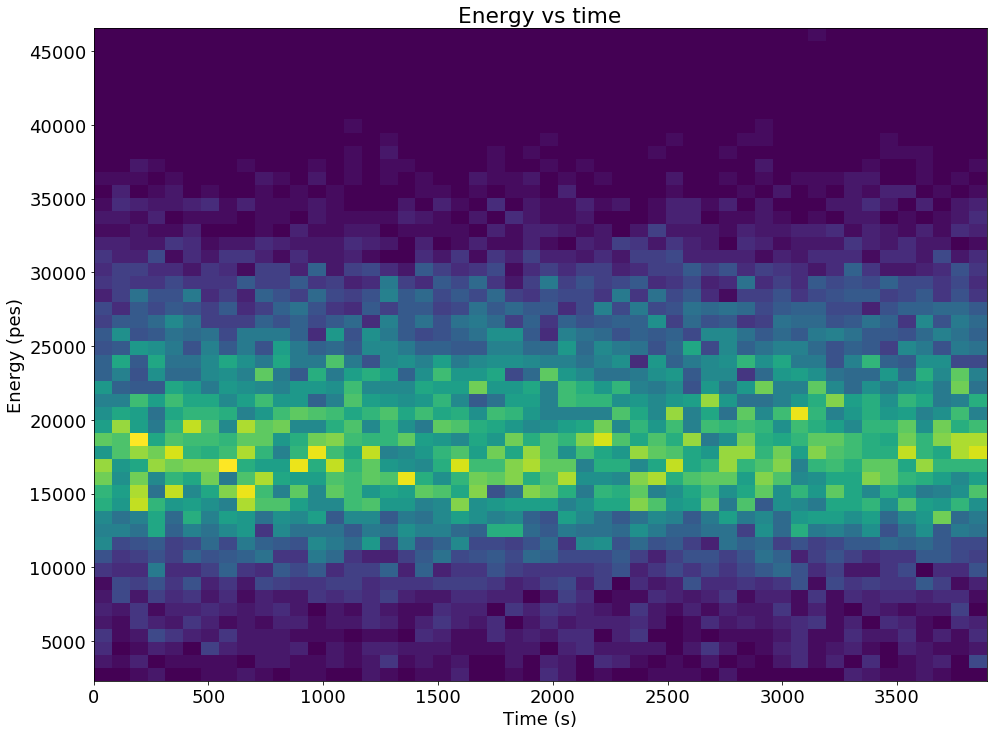

In [15]:
hist2d(full.time, full.S2e, (Tnbins, S2nbins))
labels("Time (s)", "Energy (pes)", "Energy vs time")

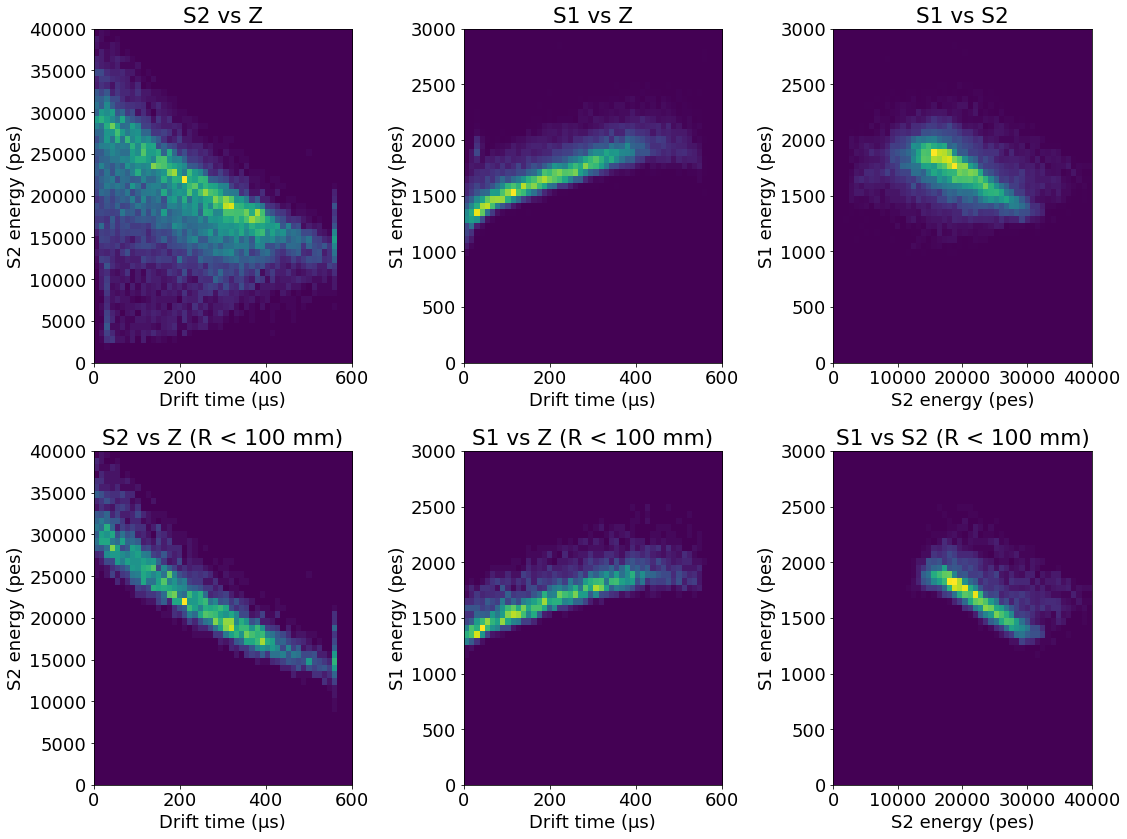

In [16]:
plt.figure()

plt.subplot(2, 3, 1)
plt.hist2d (full.Z  , full.S2e, ( Znbins, S2nbins), range=( Zrange, S2range))
labels     ("Drift time (µs)", "S2 energy (pes)", "S2 vs Z")

plt.subplot(2, 3, 2)
plt.hist2d (full.Z  , full.S1e, ( Znbins, S1nbins), range=( Zrange, S1range))
labels     ("Drift time (µs)", "S1 energy (pes)", "S1 vs Z")

plt.subplot(2, 3, 3)
plt.hist2d (full.S2e, full.S1e, (S2nbins, S1nbins), range=(S2range, S1range))
labels     ("S2 energy (pes)", "S1 energy (pes)", "S1 vs S2")

plt.subplot(2, 3, 4)
plt.hist2d (fid .Z  , fid .S2e, ( Znbins, S2nbins), range=( Zrange, S2range))
labels     ("Drift time (µs)", "S2 energy (pes)", "S2 vs Z (R < 100 mm)")

plt.subplot(2, 3, 5)
plt.hist2d (fid .Z  , fid .S1e, ( Znbins, S1nbins), range=( Zrange, S1range))
labels     ("Drift time (µs)", "S1 energy (pes)", "S1 vs Z (R < 100 mm)")

plt.subplot(2, 3, 6)
plt.hist2d (fid .S2e, fid .S1e, (S2nbins, S1nbins), range=(S2range, S1range))
labels     ("S2 energy (pes)", "S1 energy (pes)", "S1 vs S2 (R < 100 mm)")

plt.tight_layout()

# Event distribution

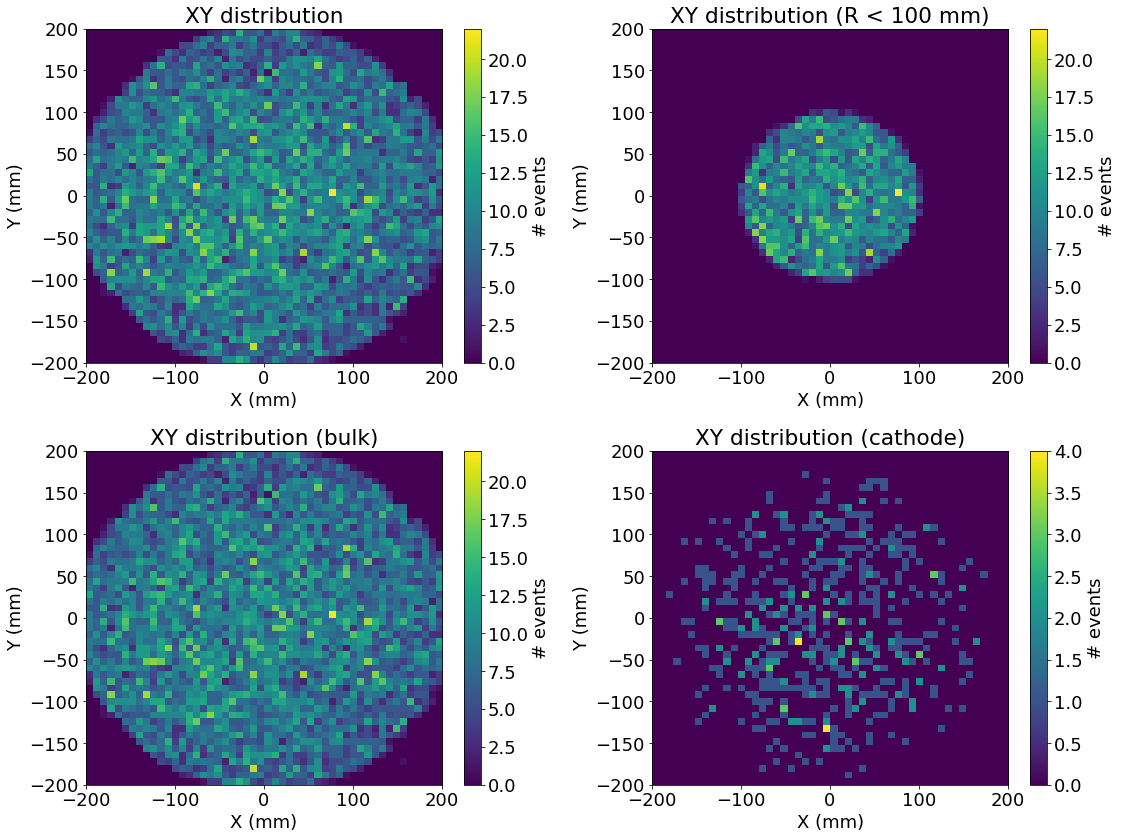

In [17]:
plt.figure ()
plt.subplot(2, 2, 1)
plt.hist2d (full.X, full.Y, XYnbins, XYrange)
plt.colorbar().set_label("# events")
labels     ("X (mm)", "Y (mm)", "XY distribution")

plt.subplot(2, 2, 2)
plt.hist2d (fid .X, fid .Y, XYnbins, XYrange)
plt.colorbar().set_label("# events")
labels     ("X (mm)", "Y (mm)", "XY distribution (R < 100 mm)")

plt.subplot(2, 2, 3)
plt.hist2d (bulk.X, bulk.Y, XYnbins, XYrange)
plt.colorbar().set_label("# events")
labels     ("X (mm)", "Y (mm)", "XY distribution (bulk)")

plt.subplot(2, 2, 4)
plt.hist2d (cath.X, cath.Y, XYnbins, XYrange)
plt.colorbar().set_label("# events")
labels     ("X (mm)", "Y (mm)", "XY distribution (cathode)")

plt.tight_layout()

# Lifetime

Energy at Z=0: ((319.2 +- 1.4) · 1e2) pes
Lifetime     : (659.1 +- 6.7) µs 
Chi2 fit     : 7.99  


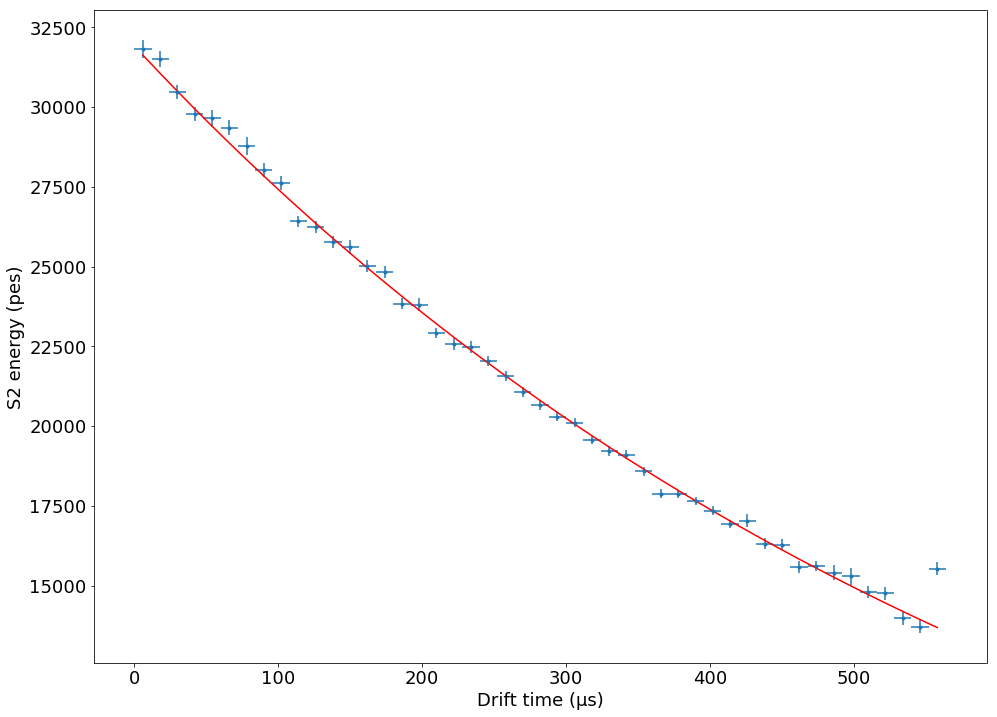

In [18]:
seed = S2range[1], -1e3

F, *_ = profile_and_fit(fid.Z, fid.S2e, 
                        xrange =  Zrange, 
                        yrange = S2range, 
                        nbins  =  Znbins, 
                        fitpar =  seed)
labels("Drift time (µs)", "S2 energy (pes)")

E0, u_E0 =  F.values[0], F.errors[0]
LT, u_LT = -F.values[1], F.errors[1]

print("Energy at Z=0: ({}) pes".format(measurement_string(E0, u_E0)))
print("Lifetime     : ({}) µs ".format(measurement_string(LT, u_LT)))
print("Chi2 fit     : {:.2f}  ".format(F.chi2))

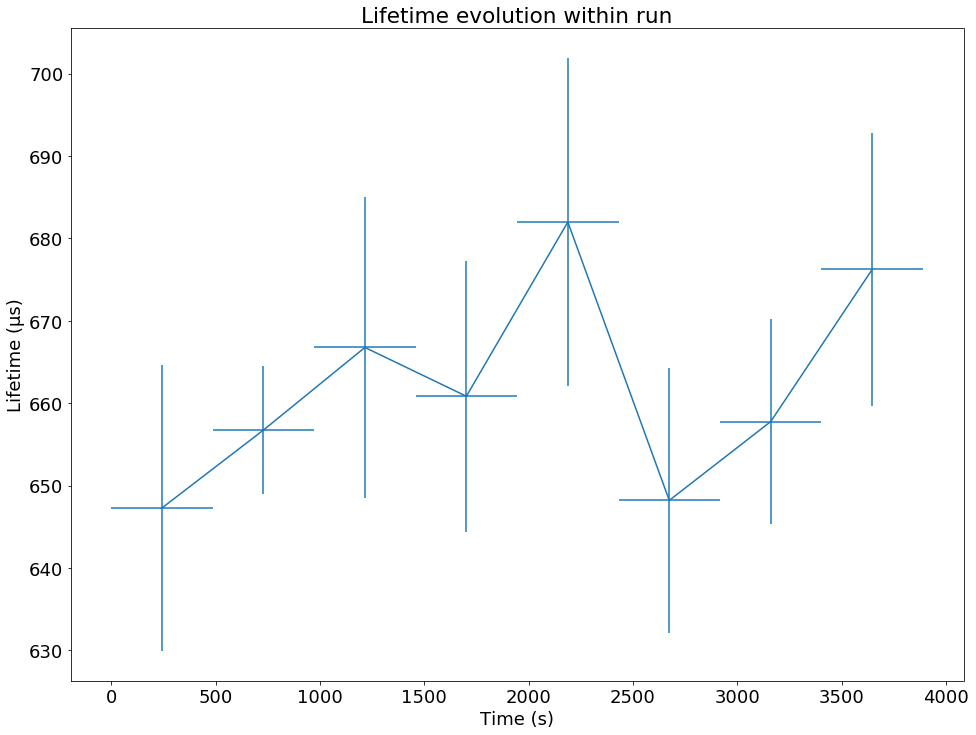

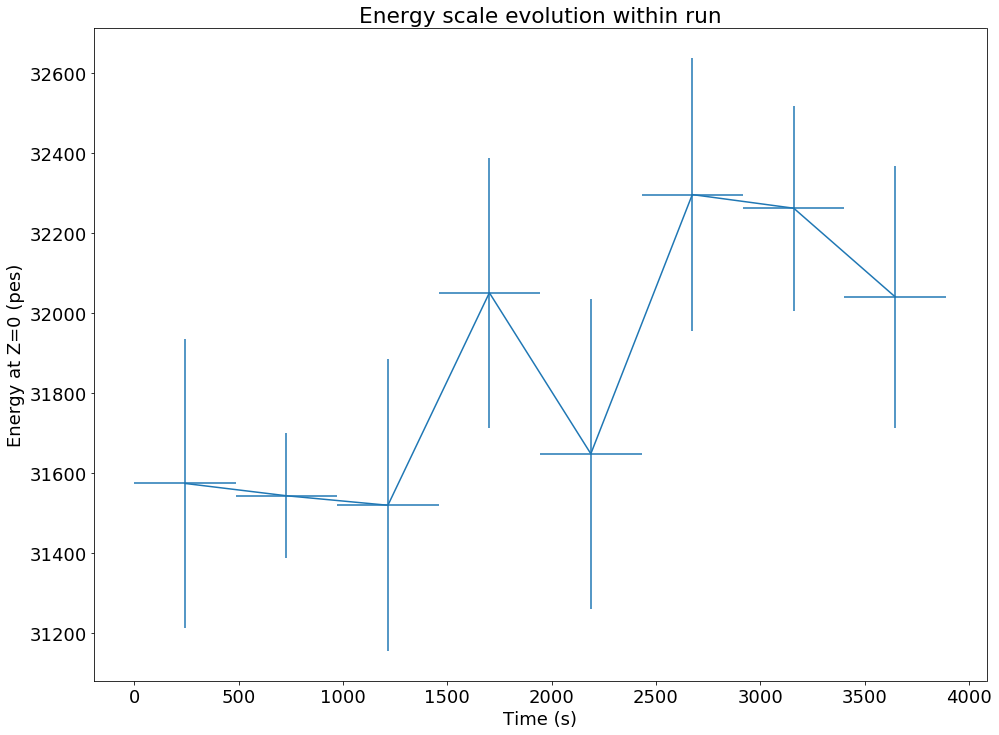

In [21]:
dst        = fid[coref.in_range(fid.Z, *Zrange)]
timestamps = list(map(time_from_timestamp, dst.time))

T, u_T, LT, u_LT, E0, u_E0 = lifetime_vs_t(dst, nslices=8, timestamps=timestamps)

errorbar(T, LT, u_LT, u_T)
labels  ("Time (s)", "Lifetime (µs)", "Lifetime evolution within run")

errorbar(T, E0, u_E0, u_T)
labels  ("Time (s)", "Energy at Z=0 (pes)", "Energy scale evolution within run")

## Drift velocity

Drift time     : (554.289 +- 0.045) µs   
Drift velocity : (0.959789 +- 0.000078) mm/µs


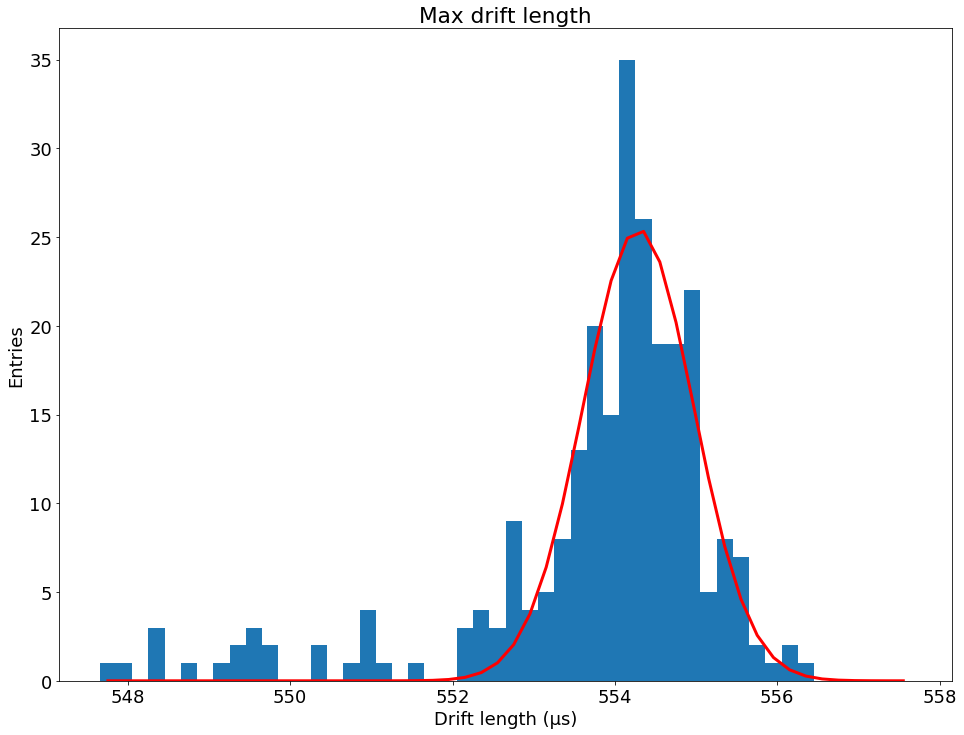

In [22]:
values, bins = np.histogram(cath.Z, 50)

mean_val = bins[np.argmax(values)]
zrange_  = mean_val - 5., mean_val + 5.

y, x, _  = hist(cath.Z, Znbins, zrange_)
F        = fitf.fit(fitf.gauss, x, y, (np.max(values), mean_val, 2))

plt.plot(x, F.fn(x), lw=3, c='r')
labels  ("Drift length (µs)", "Entries", "Max drift length")

max_drift   = F.values[1]
u_max_drift = F.errors[1] 
v_drift     = db.DetectorGeo().ZMAX[0]/max_drift
u_v_drift   = v_drift*u_max_drift/max_drift

print("Drift time     : ({}) µs   ".format(measurement_string(max_drift, u_max_drift)))
print("Drift velocity : ({}) mm/µs".format(measurement_string(  v_drift,   u_v_drift)))

# Saving data

In [23]:
date_begin = time_from_timestamp(t_begin)
date_end   = time_from_timestamp(t_end  )
date_lapse = to_deltatime       (t_begin, t_end, unit="s", to_str=True)

save_lifetime(os.path.expandvars(text_filename),
                 run_number,    run_tag,
                         LT,       u_LT,
                         E0,       u_E0,
                    v_drift,  u_v_drift,
                    t_begin,      t_end,     run_dt,
                 date_begin,   date_end, date_lapse,
                 comment   = run_comment.replace(" ", "_"),
                 delimiter = " ",
                 overwrite = overwrite)